In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [5]:
# spaCy for Greek language handling
!python -m spacy download el_core_news_md
# pandarallel for faster applying of functions to dataframes. Need for tokens, lemmas etc.
!pip install unidecode
!pip install pandarallel
print("\n")
print("INSTALLATIONS COMPLETE.")

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42.9/42.9 MB 26.4 MB/s eta 0:00:0000:0100:01
‚úî Download and installation successful
You can now load the package via spacy.load('el_core_news_md')


INSTALLATIONS COMPLETE.


In [14]:
import spacy
from pandarallel import pandarallel
from sklearn.linear_model import LogisticRegression
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata as ud
from unidecode import unidecode
from sklearn.model_selection import GridSearchCV
import optuna
from scipy.sparse import hstack
import nltk

print('Imports done.')

Imports done.


## Data Pre-processing

In [172]:
nlp = spacy.load('el_core_news_md')
df = pd.read_csv('/kaggle/input/ys19-2023-assignment-1/train_set.csv')

df.head()

New_ID                                               Text Sentiment   Party
0   35027  #Œ±œÄŒøŒªœÖŒºŒ±ŒΩœÉŒ∑_Œ∫ŒøœÅŒπŒøŒπ #Œ±œÄŒµŒΩœÑŒøŒºœâœÉŒ∑_Œ∫ŒøœÅŒπŒøœÇ #Œ±œÄŒøŒªœÖŒºŒ±...   NEUTRAL  SYRIZA
1    9531  ŒàŒæŒπ ŒΩŒ≠ŒµœÇ ŒµœÄŒπœÉœÑŒøŒªŒ≠œÇ Œ≥ŒπŒ± œÑŒ∑ ŒúŒ±Œ∫ŒµŒ¥ŒøŒΩŒØŒ± ¬´Œ∫Œ±ŒØŒΩŒµ¬ª œÑŒ∑...  NEGATIVE      ND
2   14146  ŒôœÉœáœÖœÅœå ŒöŒöŒï, Œ¥œçŒΩŒ±ŒºŒ∑ œÑŒøœÖ ŒªŒ±Œøœç œÉœÑŒ∑ ŒíŒøœÖŒªŒÆ Œ∫Œ±Œπ œÉœÑŒøœÖ...  POSITIVE     KKE
3   28716  @five2nds @anthi7vas ŒúŒΩŒ∑ŒºŒøŒΩŒπŒ±Œ∫œåœÑŒ±œÑŒø œÑŒø #ŒúŒµŒ°Œë25...   NEUTRAL     KKE
4   32886  @ai_katerina ŒëœÖœÑœå œÄŒøœÖ ŒµŒØŒΩŒ±Œπ œÉœÖŒ≥Œ∫ŒªŒøŒΩŒπœÉœÑŒπŒ∫œå ŒµŒØŒΩŒ±...   NEUTRAL  SYRIZA

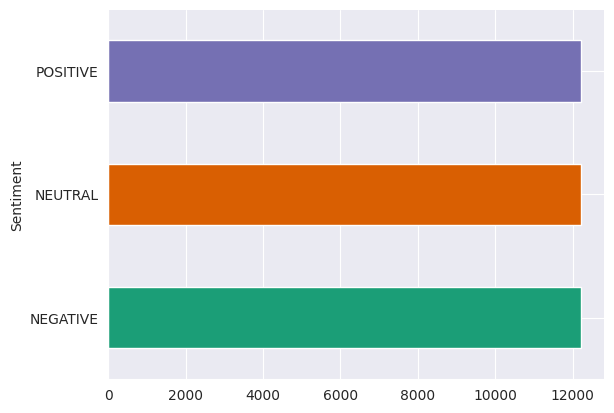

In [173]:
# Visualize our data (specifically the Sentiment column)
# Data Distribution

df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='Sentiment', ylabel='count'>

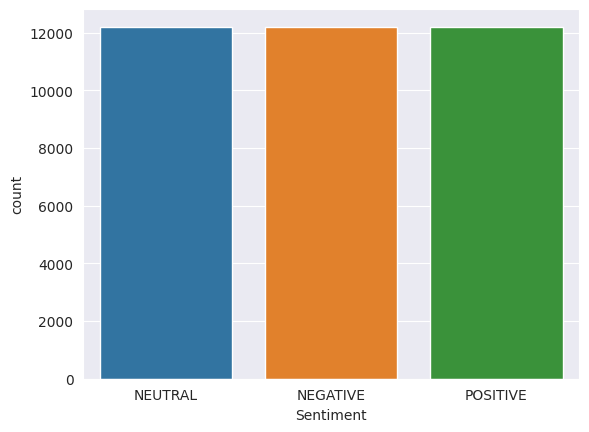

In [174]:
# Countplot for column Sentiment, Sentiment values are of the same number for each sentiment
sns.countplot(x='Sentiment',data=df)

<Axes: xlabel='Party', ylabel='count'>

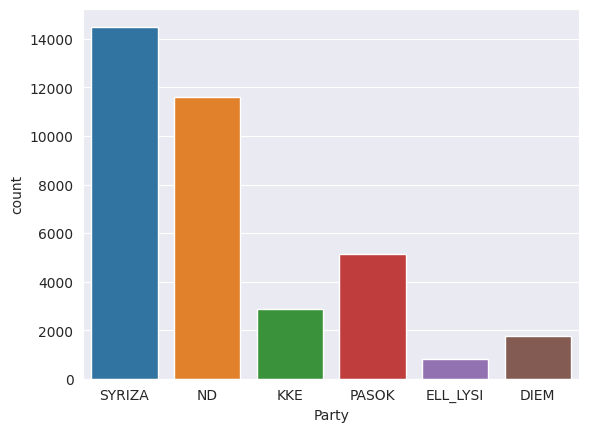

In [175]:
# Countplot for Parties , We can see that SYRIZA is the most prevalent party in the tweets dataset
sns.countplot(x='Party',data=df)

In [179]:
# Check for null values
df.isnull().sum()

# Create stop word list for word cloud and word frequency
stop_words = 'amp,Œ±Œ¥ŒπŒ±Œ∫ŒøœÄŒ±, Œ±Œπ, Œ±Œ∫ŒøŒºŒ±, Œ±Œ∫ŒøŒºŒ∑, Œ±Œ∫œÅŒπŒ≤œâœÇ, Œ±ŒªŒ∑Œ∏ŒµŒπŒ±, Œ±ŒªŒ∑Œ∏ŒπŒΩŒ±, Œ±ŒªŒªŒ±, Œ±ŒªŒªŒ±œáŒøœÖ, Œ±ŒªŒªŒµœÇ, Œ±ŒªŒªŒ∑, Œ±ŒªŒªŒ∑ŒΩ, Œ±ŒªŒªŒ∑œÇ, Œ±ŒªŒªŒπœâœÇ, Œ±ŒªŒªŒπœâœÑŒπŒ∫Œ±, Œ±ŒªŒªŒø, Œ±ŒªŒªŒøŒπ, Œ±ŒªŒªŒøŒπœâœÇ, Œ±ŒªŒªŒøŒπœâœÑŒπŒ∫Œ±, Œ±ŒªŒªŒøŒΩ, Œ±ŒªŒªŒøœÇ, Œ±ŒªŒªŒøœÑŒµ, Œ±ŒªŒªŒøœÖ, Œ±ŒªŒªŒøœÖœÇ, Œ±ŒªŒªœâŒΩ, Œ±ŒºŒ±, Œ±ŒºŒµœÉŒ±, Œ±ŒºŒµœÉœâœÇ, Œ±ŒΩ, Œ±ŒΩŒ±, Œ±ŒΩŒ±ŒºŒµœÉŒ±, Œ±ŒΩŒ±ŒºŒµœÑŒ±ŒæœÖ, Œ±ŒΩŒµœÖ, Œ±ŒΩœÑŒπ, Œ±ŒΩœÑŒπœÄŒµœÅŒ±, Œ±ŒΩœÑŒπœÇ, Œ±ŒΩœâ, Œ±ŒΩœâœÑŒµœÅœâ, Œ±ŒæŒ±œÜŒΩŒ±, Œ±œÄ, Œ±œÄŒµŒΩŒ±ŒΩœÑŒπ, Œ±œÄŒø, Œ±œÄŒøœàŒµ, Œ±œÅŒ±, Œ±œÅŒ±Œ≥Œµ, Œ±œÅŒ≥Œ±, Œ±œÅŒ≥ŒøœÑŒµœÅŒø, Œ±œÅŒπœÉœÑŒµœÅŒ±, Œ±œÅŒ∫ŒµœÑŒ±, Œ±œÅœáŒπŒ∫Œ±, Œ±œÇ, Œ±œÖœÅŒπŒø, Œ±œÖœÑŒ±, Œ±œÖœÑŒµœÇ, Œ±œÖœÑŒ∑, Œ±œÖœÑŒ∑ŒΩ, Œ±œÖœÑŒ∑œÇ, Œ±œÖœÑŒø, Œ±œÖœÑŒøŒπ, Œ±œÖœÑŒøŒΩ, Œ±œÖœÑŒøœÇ, Œ±œÖœÑŒøœÖ, Œ±œÖœÑŒøœÖœÇ, Œ±œÖœÑœâŒΩ, Œ±œÜŒøœÑŒøœÖ, Œ±œÜŒøœÖ, Œ≤ŒµŒ≤Œ±ŒπŒ±, Œ≤ŒµŒ≤Œ±ŒπŒøœÑŒ±œÑŒ±, Œ≥Œπ, Œ≥ŒπŒ±, Œ≥œÅŒ∑Œ≥ŒøœÅŒ±, Œ≥œÖœÅœâ, Œ¥Œ±, Œ¥Œµ, Œ¥ŒµŒπŒΩŒ±, Œ¥ŒµŒΩ, Œ¥ŒµŒæŒπŒ±, Œ¥Œ∑Œ∏ŒµŒΩ, Œ¥Œ∑ŒªŒ±Œ¥Œ∑, Œ¥Œπ, Œ¥ŒπŒ±, Œ¥ŒπŒ±œÅŒ∫œâœÇ, Œ¥ŒπŒ∫Œ±, Œ¥ŒπŒ∫Œø, Œ¥ŒπŒ∫ŒøŒπ, Œ¥ŒπŒ∫ŒøœÇ, Œ¥ŒπŒ∫ŒøœÖ, Œ¥ŒπŒ∫ŒøœÖœÇ, Œ¥ŒπŒøŒªŒøœÖ, Œ¥ŒπœÄŒªŒ±, Œ¥ŒπœáœâœÇ, ŒµŒ±ŒΩ, ŒµŒ±œÖœÑŒø, ŒµŒ±œÖœÑŒøŒΩ, ŒµŒ±œÖœÑŒøœÖ, ŒµŒ±œÖœÑŒøœÖœÇ, ŒµŒ±œÖœÑœâŒΩ, ŒµŒ≥Œ∫Œ±ŒπœÅŒ±, ŒµŒ≥Œ∫Œ±ŒπœÅœâœÇ, ŒµŒ≥œâ, ŒµŒ¥œâ, ŒµŒπŒ¥ŒµŒºŒ∑, ŒµŒπŒ∏Œµ, ŒµŒπŒºŒ±Œπ, ŒµŒπŒºŒ±œÉœÑŒµ, ŒµŒπŒΩŒ±Œπ, ŒµŒπœÇ, ŒµŒπœÉŒ±Œπ, ŒµŒπœÉŒ±œÉœÑŒµ, ŒµŒπœÉœÑŒµ, ŒµŒπœÑŒµ, ŒµŒπœáŒ±, ŒµŒπœáŒ±ŒºŒµ, ŒµŒπœáŒ±ŒΩ, ŒµŒπœáŒ±œÑŒµ, ŒµŒπœáŒµ, ŒµŒπœáŒµœÇ, ŒµŒ∫Œ±œÉœÑŒ±, ŒµŒ∫Œ±œÉœÑŒµœÇ, ŒµŒ∫Œ±œÉœÑŒ∑, ŒµŒ∫Œ±œÉœÑŒ∑ŒΩ, ŒµŒ∫Œ±œÉœÑŒ∑œÇ, ŒµŒ∫Œ±œÉœÑŒø, ŒµŒ∫Œ±œÉœÑŒøŒπ, ŒµŒ∫Œ±œÉœÑŒøŒΩ, ŒµŒ∫Œ±œÉœÑŒøœÇ, ŒµŒ∫Œ±œÉœÑŒøœÖ, ŒµŒ∫Œ±œÉœÑŒøœÖœÇ, ŒµŒ∫Œ±œÉœÑœâŒΩ, ŒµŒ∫ŒµŒπ, ŒµŒ∫ŒµŒπŒΩŒ±, ŒµŒ∫ŒµŒπŒΩŒµœÇ, ŒµŒ∫ŒµŒπŒΩŒ∑, ŒµŒ∫ŒµŒπŒΩŒ∑ŒΩ, ŒµŒ∫ŒµŒπŒΩŒ∑œÇ, ŒµŒ∫ŒµŒπŒΩŒø, ŒµŒ∫ŒµŒπŒΩŒøŒπ, ŒµŒ∫ŒµŒπŒΩŒøŒΩ, ŒµŒ∫ŒµŒπŒΩŒøœÇ, ŒµŒ∫ŒµŒπŒΩŒøœÖ, ŒµŒ∫ŒµŒπŒΩŒøœÖœÇ, ŒµŒ∫ŒµŒπŒΩœâŒΩ, ŒµŒ∫œÑŒøœÇ, ŒµŒºŒ±œÇ, ŒµŒºŒµŒπœÇ, ŒµŒºŒµŒΩŒ±, ŒµŒºœÄœÅŒøœÇ, ŒµŒΩ, ŒµŒΩŒ±, ŒµŒΩŒ±ŒΩ, ŒµŒΩŒ±œÇ, ŒµŒΩŒøœÇ, ŒµŒΩœÑŒµŒªœâœÇ, ŒµŒΩœÑŒøœÇ, ŒµŒΩœÑœâŒºŒµœÑŒ±ŒæœÖ, ŒµŒΩœâ, ŒµŒæ, ŒµŒæŒ±œÜŒΩŒ±, ŒµŒæŒ∑œÇ, ŒµŒæŒπœÉŒøœÖ, ŒµŒæœâ, ŒµœÄŒ±ŒΩœâ, ŒµœÄŒµŒπŒ¥Œ∑, ŒµœÄŒµŒπœÑŒ±, ŒµœÄŒπ, ŒµœÄŒπœÉŒ∑œÇ, ŒµœÄŒøŒºŒµŒΩœâœÇ, ŒµœÉŒ±œÇ, ŒµœÉŒµŒπœÇ, ŒµœÉŒµŒΩŒ±, ŒµœÉœÑœâ, ŒµœÉœÖ, ŒµœÑŒµœÅŒ±, ŒµœÑŒµœÅŒ±Œπ, ŒµœÑŒµœÅŒ±œÇ, ŒµœÑŒµœÅŒµœÇ, ŒµœÑŒµœÅŒ∑, ŒµœÑŒµœÅŒ∑œÇ, ŒµœÑŒµœÅŒø, ŒµœÑŒµœÅŒøŒπ, ŒµœÑŒµœÅŒøŒΩ, ŒµœÑŒµœÅŒøœÇ, ŒµœÑŒµœÅŒøœÖ, ŒµœÑŒµœÅŒøœÖœÇ, ŒµœÑŒµœÅœâŒΩ, ŒµœÑŒøœÖœÑŒ±, ŒµœÑŒøœÖœÑŒµœÇ, ŒµœÑŒøœÖœÑŒ∑, ŒµœÑŒøœÖœÑŒ∑ŒΩ, ŒµœÑŒøœÖœÑŒ∑œÇ, ŒµœÑŒøœÖœÑŒø, ŒµœÑŒøœÖœÑŒøŒπ, ŒµœÑŒøœÖœÑŒøŒΩ, ŒµœÑŒøœÖœÑŒøœÇ, ŒµœÑŒøœÖœÑŒøœÖ, ŒµœÑŒøœÖœÑŒøœÖœÇ, ŒµœÑŒøœÖœÑœâŒΩ, ŒµœÑœÉŒπ, ŒµœÖŒ≥Œµ, ŒµœÖŒ∏œÖœÇ, ŒµœÖœÑœÖœáœâœÇ, ŒµœÜŒµŒæŒ∑œÇ, ŒµœáŒµŒπ, ŒµœáŒµŒπœÇ, ŒµœáŒµœÑŒµ, ŒµœáŒ∏ŒµœÇ, ŒµœáŒøŒºŒµ, ŒµœáŒøœÖŒºŒµ, ŒµœáŒøœÖŒΩ, ŒµœáœÑŒµœÇ, Œµœáœâ, ŒµœâœÇ, Œ∑, Œ∑Œ¥Œ∑, Œ∑ŒºŒ±œÉœÑŒ±ŒΩ, Œ∑ŒºŒ±œÉœÑŒµ, Œ∑ŒºŒøœÖŒΩ, Œ∑œÉŒ±œÉœÑŒ±ŒΩ, Œ∑œÉŒ±œÉœÑŒµ, Œ∑œÉŒøœÖŒΩ, Œ∑œÑŒ±ŒΩ, Œ∑œÑŒ±ŒΩŒµ, Œ∑œÑŒøŒπ, Œ∑œÑœÑŒøŒΩ, Œ∏Œ±, Œπ, ŒπŒ¥ŒπŒ±, ŒπŒ¥ŒπŒ±ŒΩ, ŒπŒ¥ŒπŒ±œÇ, ŒπŒ¥ŒπŒµœÇ, ŒπŒ¥ŒπŒø, ŒπŒ¥ŒπŒøŒπ, ŒπŒ¥ŒπŒøŒΩ, ŒπŒ¥ŒπŒøœÇ, ŒπŒ¥ŒπŒøœÖ, ŒπŒ¥ŒπŒøœÖœÇ, ŒπŒ¥ŒπœâŒΩ, ŒπŒ¥ŒπœâœÇ, ŒπŒπ, ŒπŒπŒπ, ŒπœÉŒ±ŒºŒµ, ŒπœÉŒπŒ±, ŒπœÉœâœÇ,Œ∫,Œ∫Œ±Œ∏Œµ, Œ∫Œ±Œ∏ŒµŒºŒπŒ±, Œ∫Œ±Œ∏ŒµŒºŒπŒ±œÇ, Œ∫Œ±Œ∏ŒµŒΩŒ±, Œ∫Œ±Œ∏ŒµŒΩŒ±œÇ, Œ∫Œ±Œ∏ŒµŒΩŒøœÇ, Œ∫Œ±Œ∏ŒµœÑŒπ, Œ∫Œ±Œ∏ŒøŒªŒøœÖ, Œ∫Œ±Œ∏œâœÇ, Œ∫Œ±Œπ, Œ∫Œ±Œ∫Œ±, Œ∫Œ±Œ∫œâœÇ, Œ∫Œ±ŒªŒ±, Œ∫Œ±ŒªœâœÇ, Œ∫Œ±ŒºŒπŒ±, Œ∫Œ±ŒºŒπŒ±ŒΩ, Œ∫Œ±ŒºŒπŒ±œÇ, Œ∫Œ±ŒºœÄŒøœÉŒ±, Œ∫Œ±ŒºœÄŒøœÉŒµœÇ, Œ∫Œ±ŒºœÄŒøœÉŒ∑, Œ∫Œ±ŒºœÄŒøœÉŒ∑ŒΩ, Œ∫Œ±ŒºœÄŒøœÉŒ∑œÇ, Œ∫Œ±ŒºœÄŒøœÉŒø, Œ∫Œ±ŒºœÄŒøœÉŒøŒπ, Œ∫Œ±ŒºœÄŒøœÉŒøŒΩ, Œ∫Œ±ŒºœÄŒøœÉŒøœÇ, Œ∫Œ±ŒºœÄŒøœÉŒøœÖ, Œ∫Œ±ŒºœÄŒøœÉŒøœÖœÇ, Œ∫Œ±ŒºœÄŒøœÉœâŒΩ, Œ∫Œ±ŒΩŒµŒπœÇ, Œ∫Œ±ŒΩŒµŒΩ, Œ∫Œ±ŒΩŒµŒΩŒ±, Œ∫Œ±ŒΩŒµŒΩŒ±ŒΩ, Œ∫Œ±ŒΩŒµŒΩŒ±œÇ, Œ∫Œ±ŒΩŒµŒΩŒøœÇ, Œ∫Œ±œÄŒøŒπŒ±, Œ∫Œ±œÄŒøŒπŒ±ŒΩ, Œ∫Œ±œÄŒøŒπŒ±œÇ, Œ∫Œ±œÄŒøŒπŒµœÇ, Œ∫Œ±œÄŒøŒπŒø, Œ∫Œ±œÄŒøŒπŒøŒπ, Œ∫Œ±œÄŒøŒπŒøŒΩ, Œ∫Œ±œÄŒøŒπŒøœÇ, Œ∫Œ±œÄŒøŒπŒøœÖ, Œ∫Œ±œÄŒøŒπŒøœÖœÇ, Œ∫Œ±œÄŒøŒπœâŒΩ, Œ∫Œ±œÄŒøœÑŒµ, Œ∫Œ±œÄŒøœÖ, Œ∫Œ±œÄœâœÇ, Œ∫Œ±œÑ ,Œ∫Œ±œÑŒ±, Œ∫Œ±œÑŒπ, Œ∫Œ±œÑŒπœÑŒπ, Œ∫Œ±œÑŒøœÄŒπŒΩ, Œ∫Œ±œÑœâ, Œ∫ŒπŒøŒªŒ±œÇ,Œ∫Œπ, Œ∫ŒªœÄ, Œ∫ŒøŒΩœÑŒ±, Œ∫œÑŒª, Œ∫œÖœÅŒπœâœÇ, ŒªŒπŒ≥Œ±Œ∫Œπ, ŒªŒπŒ≥Œø, ŒªŒπŒ≥œâœÑŒµœÅŒø, ŒªŒøŒ≥œâ, ŒªŒøŒπœÄŒ±, ŒªŒøŒπœÄŒøŒΩ, ŒºŒ±, ŒºŒ±Œ∂Œπ, ŒºŒ±Œ∫Œ±œÅŒπ, ŒºŒ±Œ∫œÅœÖŒ±, ŒºŒ±ŒªŒπœÉœÑŒ±, ŒºŒ±ŒªŒªŒøŒΩ, ŒºŒ±œÇ, ŒºŒµ, ŒºŒµŒ∏Œ±œÖœÅŒπŒø, ŒºŒµŒπŒøŒΩ, ŒºŒµŒªŒµŒπ, ŒºŒµŒªŒªŒµœÑŒ±Œπ, ŒºŒµŒºŒπŒ±œÇ, ŒºŒµŒΩ, ŒºŒµœÅŒπŒ∫Œ±, ŒºŒµœÅŒπŒ∫ŒµœÇ, ŒºŒµœÅŒπŒ∫ŒøŒπ, ŒºŒµœÅŒπŒ∫ŒøœÖœÇ, ŒºŒµœÅŒπŒ∫œâŒΩ, ŒºŒµœÉŒ±, ŒºŒµœÑ, ŒºŒµœÑŒ±, ŒºŒµœÑŒ±ŒæœÖ, ŒºŒµœáœÅŒπ, ŒºŒ∑, ŒºŒ∑Œ¥Œµ, ŒºŒ∑ŒΩ, ŒºŒ∑œÄœâœÇ, ŒºŒ∑œÑŒµ, ŒºŒπŒ±, ŒºŒπŒ±ŒΩ, ŒºŒπŒ±œÇ, ŒºŒøŒªŒπœÇ, ŒºŒøŒªŒøŒΩŒøœÑŒπ, ŒºŒøŒΩŒ±œáŒ±, ŒºŒøŒΩŒµœÇ, ŒºŒøŒΩŒ∑, ŒºŒøŒΩŒ∑ŒΩ, ŒºŒøŒΩŒ∑œÇ, ŒºŒøŒΩŒø, ŒºŒøŒΩŒøŒπ, ŒºŒøŒΩŒøŒºŒπŒ±œÇ, ŒºŒøŒΩŒøœÇ, ŒºŒøŒΩŒøœÖ, ŒºŒøŒΩŒøœÖœÇ, ŒºŒøŒΩœâŒΩ, ŒºŒøœÖ, ŒºœÄŒøœÅŒµŒπ, ŒºœÄŒøœÅŒøœÖŒΩ, ŒºœÄœÅŒ±Œ≤Œø, ŒºœÄœÅŒøœÇ, ŒΩŒ±, ŒΩŒ±Œπ, ŒΩœâœÅŒπœÇ, ŒæŒ±ŒΩŒ±, ŒæŒ±œÜŒΩŒπŒ∫Œ±, Œø, ŒøŒπ, ŒøŒªŒ±, ŒøŒªŒµœÇ, ŒøŒªŒ∑, ŒøŒªŒ∑ŒΩ, ŒøŒªŒ∑œÇ, ŒøŒªŒø, ŒøŒªŒøŒ≥œÖœÅŒ±, ŒøŒªŒøŒπ, ŒøŒªŒøŒΩ, ŒøŒªŒøŒΩŒµŒΩ, ŒøŒªŒøœÇ, ŒøŒªŒøœÑŒµŒªŒ±, ŒøŒªŒøœÖ, ŒøŒªŒøœÖœÇ, ŒøŒªœâŒΩ, ŒøŒªœâœÇ, ŒøŒªœâœÉŒ¥ŒπŒøŒªŒøœÖ, ŒøŒºœâœÇ, ŒøœÄŒøŒπŒ±, ŒøœÄŒøŒπŒ±Œ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒ±ŒΩ, ŒøœÄŒøŒπŒ±ŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒ±œÇ, ŒøœÄŒøŒπŒ±œÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒµœÇ, ŒøœÄŒøŒπŒµœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒø, ŒøœÄŒøŒπŒøŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒøŒπ, ŒøœÄŒøŒπŒøŒΩ, ŒøœÄŒøŒπŒøŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒøœÇ, ŒøœÄŒøŒπŒøœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒøœÖ, ŒøœÄŒøŒπŒøœÖŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒøœÖœÇ, ŒøœÄŒøŒπŒøœÖœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπœâŒΩ, ŒøœÄŒøŒπœâŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøœÑŒµ, ŒøœÄŒøœÑŒµŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøœÖ, ŒøœÄŒøœÖŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄœâœÇ, ŒøœÅŒπœÉŒºŒµŒΩŒ±, ŒøœÅŒπœÉŒºŒµŒΩŒµœÇ, ŒøœÅŒπœÉŒºŒµŒΩœâŒΩ, ŒøœÅŒπœÉŒºŒµŒΩœâœÇ, ŒøœÉŒ±, ŒøœÉŒ±Œ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒµœÇ, ŒøœÉŒµœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒ∑, ŒøœÉŒ∑Œ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒ∑ŒΩ, ŒøœÉŒ∑ŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒ∑œÇ, ŒøœÉŒ∑œÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒø, ŒøœÉŒøŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøŒπ, ŒøœÉŒøŒπŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøŒΩ, ŒøœÉŒøŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøœÇ, ŒøœÉŒøœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøœÖ, ŒøœÉŒøœÖŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøœÖœÇ, ŒøœÉŒøœÖœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉœâŒΩ, ŒøœÉœâŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÑŒ±ŒΩ, ŒøœÑŒπ, ŒøœÑŒπŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÑŒøœÖ, ŒøœÖ, ŒøœÖŒ¥Œµ, ŒøœÖœÑŒµ, ŒøœáŒπ, œÄŒ±ŒªŒπ, œÄŒ±ŒΩœÑŒøœÑŒµ, œÄŒ±ŒΩœÑŒøœÖ, œÄŒ±ŒΩœÑœâœÇ, œÄŒ±œÅŒ±, œÄŒµœÅŒ±, œÄŒµœÅŒπ, œÄŒµœÅŒπœÄŒøœÖ, œÄŒµœÅŒπœÉœÉŒøœÑŒµœÅŒø, œÄŒµœÅœÉŒπ, œÄŒµœÅœÖœÉŒπ, œÄŒπŒ±, œÄŒπŒ∏Œ±ŒΩŒøŒΩ, œÄŒπŒø, œÄŒπœÉœâ, œÄŒªŒ±Œπ, œÄŒªŒµŒøŒΩ, œÄŒªŒ∑ŒΩ, œÄŒøŒπŒ±, œÄŒøŒπŒ±ŒΩ, œÄŒøŒπŒ±œÇ, œÄŒøŒπŒµœÇ, œÄŒøŒπŒø, œÄŒøŒπŒøŒπ, œÄŒøŒπŒøŒΩ, œÄŒøŒπŒøœÇ, œÄŒøŒπŒøœÖ, œÄŒøŒπŒøœÖœÇ, œÄŒøŒπœâŒΩ, œÄŒøŒªœÖ, œÄŒøœÉŒµœÇ, œÄŒøœÉŒ∑, œÄŒøœÉŒ∑ŒΩ, œÄŒøœÉŒ∑œÇ, œÄŒøœÉŒøŒπ, œÄŒøœÉŒøœÇ, œÄŒøœÉŒøœÖœÇ, œÄŒøœÑŒµ, œÄŒøœÖ, œÄŒøœÖŒ∏Œµ, œÄŒøœÖŒ∏ŒµŒΩŒ±, œÄœÅŒµœÄŒµŒπ, œÄœÅŒπŒΩ, œÄœÅŒø, œÄœÅŒøŒ∫ŒµŒπŒºŒµŒΩŒøœÖ, œÄœÅŒøŒ∫ŒµŒπœÑŒ±Œπ, œÄœÅŒøœÄŒµœÅœÉŒπ, œÄœÅŒøœÇ, œÄœÅŒøœÑŒøœÖ, œÄœÅŒøœáŒ∏ŒµœÇ, œÄœÅŒøœáœÑŒµœÇ, œÄœÅœâœÑœÖœÑŒµœÅŒ±, œÄœâœÇ, œÉŒ±ŒΩ, œÉŒ±œÇ, œÉŒµ, œÉŒµŒπœÇ, œÉŒ∑ŒºŒµœÅŒ±, œÉŒπŒ≥Œ±, œÉŒøœÖ, œÉœÑŒ±, œÉœÑŒ∑, œÉœÑŒ∑ŒΩ, œÉœÑŒ∑œÇ, œÉœÑŒπœÇ, œÉœÑŒø, œÉœÑŒøŒΩ, œÉœÑŒøœÖ, œÉœÑŒøœÖœÇ, œÉœÑœâŒΩ, œÉœÖŒ≥œáœÅŒøŒΩœâœÇ, œÉœÖŒΩ, œÉœÖŒΩŒ±ŒºŒ±, œÉœÖŒΩŒµœÄœâœÇ, œÉœÖŒΩŒ∑Œ∏œâœÇ, œÉœÖœáŒΩŒ±, œÉœÖœáŒΩŒ±œÇ, œÉœÖœáŒΩŒµœÇ, œÉœÖœáŒΩŒ∑, œÉœÖœáŒΩŒ∑ŒΩ, œÉœÖœáŒΩŒ∑œÇ, œÉœÖœáŒΩŒø, œÉœÖœáŒΩŒøŒπ, œÉœÖœáŒΩŒøŒΩ, œÉœÖœáŒΩŒøœÇ, œÉœÖœáŒΩŒøœÖ, œÉœÖœáŒΩŒøœÖ, œÉœÖœáŒΩŒøœÖœÇ, œÉœÖœáŒΩœâŒΩ, œÉœÖœáŒΩœâœÇ, œÉœáŒµŒ¥ŒøŒΩ, œÉœâœÉœÑŒ±, œÑŒ±, œÑŒ±Œ¥Œµ, œÑŒ±œÖœÑŒ±, œÑŒ±œÖœÑŒµœÇ, œÑŒ±œÖœÑŒ∑, œÑŒ±œÖœÑŒ∑ŒΩ, œÑŒ±œÖœÑŒ∑œÇ, œÑŒ±œÖœÑŒø,œÑŒ±œÖœÑŒøŒΩ, œÑŒ±œÖœÑŒøœÇ, œÑŒ±œÖœÑŒøœÖ, œÑŒ±œÖœÑœâŒΩ, œÑŒ±œáŒ±, œÑŒ±œáŒ±œÑŒµ, œÑŒµŒªŒπŒ∫Œ±, œÑŒµŒªŒπŒ∫œâœÇ, œÑŒµœÇ, œÑŒµœÑŒøŒπŒ±, œÑŒµœÑŒøŒπŒ±ŒΩ, œÑŒµœÑŒøŒπŒ±œÇ, œÑŒµœÑŒøŒπŒµœÇ, œÑŒµœÑŒøŒπŒø, œÑŒµœÑŒøŒπŒøŒπ, œÑŒµœÑŒøŒπŒøŒΩ, œÑŒµœÑŒøŒπŒøœÇ, œÑŒµœÑŒøŒπŒøœÖ, œÑŒµœÑŒøŒπŒøœÖœÇ, œÑŒµœÑŒøŒπœâŒΩ, œÑŒ∑, œÑŒ∑ŒΩ, œÑŒ∑œÇ, œÑŒπ, œÑŒπœÄŒøœÑŒ±, œÑŒπœÄŒøœÑŒµ, œÑŒπœÇ, œÑŒø, œÑŒøŒπ, œÑŒøŒΩ, œÑŒøœÇ, œÑŒøœÉŒ±, œÑŒøœÉŒµœÇ, œÑŒøœÉŒ∑, œÑŒøœÉŒ∑ŒΩ, œÑŒøœÉŒ∑œÇ, œÑŒøœÉŒø, œÑŒøœÉŒøŒπ, œÑŒøœÉŒøŒΩ, œÑŒøœÉŒøœÇ, œÑŒøœÉŒøœÖ, œÑŒøœÉŒøœÖœÇ, œÑŒøœÉœâŒΩ, œÑŒøœÑŒµ, œÑŒøœÖ, œÑŒøœÖŒªŒ±œáŒπœÉœÑŒø, œÑŒøœÖŒªŒ±œáŒπœÉœÑŒøŒΩ, œÑŒøœÖœÇ, œÑŒøœÖœÑŒ±, œÑŒøœÖœÑŒµœÇ, œÑŒøœÖœÑŒ∑, œÑŒøœÖœÑŒ∑ŒΩ, œÑŒøœÖœÑŒ∑œÇ, œÑŒøœÖœÑŒø, œÑŒøœÖœÑŒøŒπ, œÑŒøœÖœÑŒøŒπœÇ, œÑŒøœÖœÑŒøŒΩ, œÑŒøœÖœÑŒøœÇ, œÑŒøœÖœÑŒøœÖ, œÑŒøœÖœÑŒøœÖœÇ, œÑŒøœÖœÑœâŒΩ, œÑœÖœáŒøŒΩ, œÑœâŒΩ, œÑœâœÅŒ±, œÖœÄ, œÖœÄŒµœÅ, œÖœÄŒø, œÖœÄŒøœàŒ∑, œÖœÄŒøœàŒπŒΩ, œÖœÉœÑŒµœÅŒ±, œÜŒµœÑŒøœÇ, œáŒ±ŒºŒ∑ŒªŒ±, œáŒ∏ŒµœÇ, œáœÑŒµœÇ, œáœâœÅŒπœÇ, œáœâœÅŒπœÉœÑŒ±, œàŒ∑ŒªŒ±, œâ, œâœÅŒ±ŒπŒ±, œâœÇ, œâœÉŒ±ŒΩ, œâœÉŒøœÑŒøœÖ, œâœÉœÄŒøœÖ, œâœÉœÑŒµ, œâœÉœÑŒøœÉŒø, œâœá'


stop_words_separated = stop_words.split(",")
stop_words_separated = [w.strip() for w in stop_words_separated] # remove whitespaces

# remove diacritics
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

for word in stop_words_separated:
    word = ud.normalize('NFD',word).translate(d)

print('Stop words created.')

Stop words created.


In [196]:
# Data cleanup
# Remove all useless characters from tweets (URLs, Hashtags, mentions (at signs), punctuations)
# also removes mentioned accounts after hashtags and @ signs and special symbols.
def clean_tweet(tweet):
    '''
    Function to clean a tweet text by removing the links, punctuations, hashtags, mentions symbols and every text after mentions and hashtags
    using regex expressions. Also removes special symbols.
    Parameters:
       tweet (string): Tweet text to transform.
    Returns:
       tweet_cleaned (string): Tweet without links, punctuations, hashtags, ,mentions symbols and every text after mentions and hashtags. Also removes special symbols.
    """
    '''
    # convert the tweet text to lowercase letters
    tweet_lower = tweet.lower()
    # remove links, punctuations, hashtags, ,mentions and other symbols
    tweet_cleaned = re.sub(u"(http\S+)|([‚Äú‚Äù!?.¬ª¬´,:;()\"%&-])|([#@]\S+)|", "", tweet_lower)
    
    return tweet_cleaned

# Apply function to all tweets (text column)
df['Text'] = [clean_tweet(tweet) for tweet in df['Text']]

def find_english_words(text):
    return re.findall(r'\b[a-zA-Z]+\b', text)

english_words = [find_english_words(text) for text in df['Text']]
eng_word_sep = [(",").join(word) for word in english_words]



# remove diacritics from Text column
text_no_diacritics = []
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
for tweet in df['Text']:
    text1 = ud.normalize('NFD',tweet).translate(d)
    text_no_diacritics.append(text1)

df['Text'] = text_no_diacritics

# Remove stop_words from text column
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))

print(df['Text']) # making sure the cleanup works.

# Using pandarallel for faster tokenization and lemmatization.
# pandarallel.initialize(progress_bar=True)

# I added comments to these columns as they took a considerable amount of time to be finished , and they're not usable
# since they produce worse results.
# df['Docs'] = df['Text'].parallel_apply(lambda x: nlp(x)) # add docs to dataframe in order to get tokens
# df['Lemmas'] = df['Text'].parallel_apply(lambda row: " ".join([w.lemma_ for w in nlp(row)])) # add lemmas to dataframe
print("Text cleanup complete.")

0        Œ∫œÖœÅŒπŒ±Œ∫Œ∑ Œ∫ŒøœÅŒπŒøŒπ Œ±œÄŒøŒªœÖŒºŒ±ŒΩœÉŒ∑ Œ∫Œ±œÑŒ±œÄŒøŒªŒµŒºŒ∑œÉŒ∑ Œ∫ŒøœÅŒπœâŒΩ ...
1        ŒµŒæŒπ ŒΩŒµŒµœÇ ŒµœÄŒπœÉœÑŒøŒªŒµœÇ ŒºŒ±Œ∫ŒµŒ¥ŒøŒΩŒπŒ± Œ∫Œ±ŒπŒΩŒµ ŒΩŒ¥ ŒºŒ∑œÑœÉŒøœÑŒ±Œ∫...
2         ŒπœÉœáœÖœÅŒø Œ∫Œ∫Œµ Œ¥œÖŒΩŒ±ŒºŒ∑ ŒªŒ±ŒøœÖ Œ≤ŒøœÖŒªŒ∑ Œ∫Œ±Œ∏Œ∑ŒºŒµœÅŒπŒΩŒøœÖœÇ Œ±Œ≥œâŒΩŒµœÇ
3                                           ŒºŒΩŒ∑ŒºŒøŒΩŒπŒ±Œ∫ŒøœÑŒ±œÑŒø
4                         œÉœÖŒ≥Œ∫ŒªŒøŒΩŒπœÉœÑŒπŒ∫Œø œàœÖœáŒ±œÉŒ∏ŒµŒΩŒµŒπŒ± œÑœÉŒπœÄœÅŒ±
                               ...                        
36625    Œ∫ŒøœÖŒªŒ∑œÇ ŒºŒ∑œÑœÉŒøœÑŒ±Œ∫Œ∑œÇ ŒªŒµŒµŒπ œàŒµŒºŒ±œÑŒ±Œ¥ŒµŒΩ Œ±Œ¥ŒµŒπŒ±œÉŒµ ŒºœÄŒ±ŒºœÄ...
36626    œÄœÅŒøœÉŒµŒæŒµ œÉŒ∫ŒπœÉŒµŒπ Œ∫Œ±ŒªœÉŒøŒΩ œáŒ±ŒªŒπŒ± ŒΩŒµŒ± œÜœâœÑŒøŒ≥œÅŒ±œÜŒπŒ± ŒøŒºŒø...
36627    Œ∏ŒµœÉŒ∑ Œ∫Œ∫Œµ Œ±œÉœÜŒ±ŒªŒµŒπŒ± œÄŒøŒªŒπœÑœâŒΩ Œ¥ŒπŒ±œÜŒøœÅŒøœÖœÇ œÅŒøœÖŒ≤ŒπŒ∫œâŒΩŒµœÇ...
36628    ŒºŒ±œÅŒ∑ Œ∫Œ±Œ∫ŒøŒºŒøŒπœÅŒ± Œ∏œÖŒ≥Œ±œÑŒµœÅŒ± ŒΩŒ±Œ∂ŒπœÉœÑŒ∑ Œ±ŒΩœÑŒπœÉŒ∑ŒºŒπœÑŒ∑ ŒæŒµœÜ...
36629                              ŒµŒΩœÑŒ±ŒæŒµŒπ ŒµœÄŒµŒπœÉŒµœÇ Œ∫Œ∫Œµ ü§ò‚ù§Ô

In [225]:
eng_word_sep = [(",").join(word) for word in english_words]
def lists_to_string_skip_empty(list_of_lists):
   # Flatten the list of lists, skipping empty lists
   flat_list = [item for sublist in list_of_lists if sublist for item in sublist]
   # Convert the flat list to a comma-separated string
   return ', '.join(flat_list)

eng_word_sep_no_empty = [item for item in eng_word_sep if item != '']
eng_word_no_dupes = list(set(eng_word_sep_no_empty))
# final_list = lists_to_string_skip_empty(eng_word_sep)
# print(english_words)
print(eng_word_sep)
# print(final_list)

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'news', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'newsbomb', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

In [197]:
# Creating some visualizations with tokens
# Word cloud
tweets = []
for tweet in df['Text']:
    #tokens.append(doc.text)
    tweets.append(tweet)
    
print(len(tweets))
print(stop_words_separated)

# stop_words = stopwords.words('greek')
for i in range(len(tweets)):
        tweets[i] = tweets[i].lower()


# remove Diacritics in Greek (tonous)
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
tweets_string = "".join(tweets)
tweets_without_accent = ud.normalize('NFD',tweets_string).translate(d)
    
print(type(tweets_without_accent))

wordcloud = WordCloud(stopwords=stop_words_separated).generate(str(tweets_without_accent))
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

36630
['amp', 'Œ±Œ¥ŒπŒ±Œ∫ŒøœÄŒ±', 'Œ±Œπ', 'Œ±Œ∫ŒøŒºŒ±', 'Œ±Œ∫ŒøŒºŒ∑', 'Œ±Œ∫œÅŒπŒ≤œâœÇ', 'Œ±ŒªŒ∑Œ∏ŒµŒπŒ±', 'Œ±ŒªŒ∑Œ∏ŒπŒΩŒ±', 'Œ±ŒªŒªŒ±', 'Œ±ŒªŒªŒ±œáŒøœÖ', 'Œ±ŒªŒªŒµœÇ', 'Œ±ŒªŒªŒ∑', 'Œ±ŒªŒªŒ∑ŒΩ', 'Œ±ŒªŒªŒ∑œÇ', 'Œ±ŒªŒªŒπœâœÇ', 'Œ±ŒªŒªŒπœâœÑŒπŒ∫Œ±', 'Œ±ŒªŒªŒø', 'Œ±ŒªŒªŒøŒπ', 'Œ±ŒªŒªŒøŒπœâœÇ', 'Œ±ŒªŒªŒøŒπœâœÑŒπŒ∫Œ±', 'Œ±ŒªŒªŒøŒΩ', 'Œ±ŒªŒªŒøœÇ', 'Œ±ŒªŒªŒøœÑŒµ', 'Œ±ŒªŒªŒøœÖ', 'Œ±ŒªŒªŒøœÖœÇ', 'Œ±ŒªŒªœâŒΩ', 'Œ±ŒºŒ±', 'Œ±ŒºŒµœÉŒ±', 'Œ±ŒºŒµœÉœâœÇ', 'Œ±ŒΩ', 'Œ±ŒΩŒ±', 'Œ±ŒΩŒ±ŒºŒµœÉŒ±', 'Œ±ŒΩŒ±ŒºŒµœÑŒ±ŒæœÖ', 'Œ±ŒΩŒµœÖ', 'Œ±ŒΩœÑŒπ', 'Œ±ŒΩœÑŒπœÄŒµœÅŒ±', 'Œ±ŒΩœÑŒπœÇ', 'Œ±ŒΩœâ', 'Œ±ŒΩœâœÑŒµœÅœâ', 'Œ±ŒæŒ±œÜŒΩŒ±', 'Œ±œÄ', 'Œ±œÄŒµŒΩŒ±ŒΩœÑŒπ', 'Œ±œÄŒø', 'Œ±œÄŒøœàŒµ', 'Œ±œÅŒ±', 'Œ±œÅŒ±Œ≥Œµ', 'Œ±œÅŒ≥Œ±', 'Œ±œÅŒ≥ŒøœÑŒµœÅŒø', 'Œ±œÅŒπœÉœÑŒµœÅŒ±', 'Œ±œÅŒ∫ŒµœÑŒ±', 'Œ±œÅœáŒπŒ∫Œ±', 'Œ±œÇ', 'Œ±œÖœÅŒπŒø', 'Œ±œÖœÑŒ±', 'Œ±œÖœÑŒµœÇ', 'Œ±œÖœÑŒ∑', 'Œ±œÖœÑŒ∑ŒΩ', 'Œ±œÖœÑŒ∑œÇ', 'Œ±œÖœÑŒø', 'Œ±œÖœÑŒøŒπ', 'Œ±œÖœÑŒøŒΩ', 'Œ±œÖœÑŒøœÇ', 'Œ±œÖœÑŒøœÖ', 'Œ±œÖœÑŒøœÖœÇ', 'Œ±œÖœÑœâŒΩ', 'Œ±œÜŒøœÑŒøœÖ', 'Œ±œÜŒøœÖ', 'Œ≤ŒµŒ≤Œ±ŒπŒ±', 'Œ≤ŒµŒ≤Œ

AttributeError: 'list' object has no attribute 'lower'

Œ∫ŒøœÖŒªŒ∑œÇ ŒºŒ∑œÑœÉŒøœÑŒ±Œ∫Œ∑œÇ ŒªŒµŒµŒπ œàŒµŒºŒ±œÑŒ±Œ¥ŒµŒΩ Œ±Œ¥ŒµŒπŒ±œÉŒµ ŒºœÄŒ±ŒºœÄŒ∑ œÄŒ±œÄŒ±Œ¥Œ∑ŒºŒ∑œÑœÅŒπŒøœÖŒø ŒºœÄŒ±ŒºœÄŒ∑œÇ œÄœÅŒøŒµœÑŒøŒπŒºŒ±Œ∂ŒµŒπ ŒµœÅœáŒµœÑŒ±Œπ Œ∫ŒøœÖŒªŒ∑ ŒºŒ∑œÑœÉŒøœÑŒ±Œ∫Œ∑ŒæŒ±œÜŒ±œÉœÑŒøœÖœÅŒΩŒ±œÅŒ±4 ŒºŒΩŒ∑ŒºŒøŒΩŒπŒø ŒµœÄŒπœÉœÑœÅŒøœÜŒ∑ ŒºŒµœÉŒ±ŒπœâŒΩŒ±
œÄœÅŒøœÉŒµŒæŒµ œÉŒ∫ŒπœÉŒµŒπ Œ∫Œ±ŒªœÉŒøŒΩ œáŒ±ŒªŒπŒ± ŒΩŒµŒ± œÜœâœÑŒøŒ≥œÅŒ±œÜŒπŒ± ŒøŒºŒøœÅœÜŒ∑ œÄœÅŒ±Œ≥ŒºŒ±œÑŒπŒ∫ŒøœÑŒ∑œÑŒ±
ŒºŒ±œÅŒ∑ Œ∫Œ±Œ∫ŒøŒºŒøŒπœÅŒ± Œ∏œÖŒ≥Œ±œÑŒµœÅŒ± ŒΩŒ±Œ∂ŒπœÉœÑŒ∑ Œ±ŒΩœÑŒπœÉŒ∑ŒºŒπœÑŒ∑ ŒæŒµœÜœÑŒπŒªŒπœÉœÑŒµŒπ œÑœÅŒøŒª ŒΩŒ¥ œÉœáŒøŒªŒπŒ±Œ∂ŒøœÖŒΩ ŒΩœÑœÅŒøœÄŒ∑ ŒºœÄŒøœÅŒµŒπœÇ œÄŒ±ŒΩœÑŒ± ŒªŒπœÄŒøŒ∏œÖŒºŒ∑œÉŒµŒπœÇ ŒΩŒ±Œ∂ŒπœÉœÑŒµœÇ œÜŒπŒªŒøŒπ


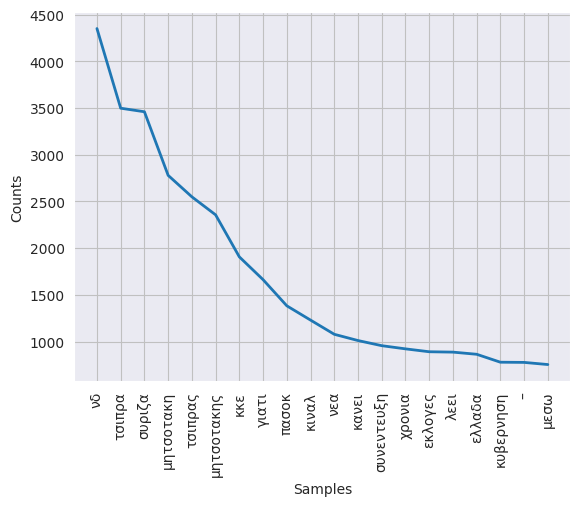

In [184]:
# Tokens frequency diagram
tokens = nltk.word_tokenize(tweets_without_accent)
  

print(df['Text'][36625])
print(df['Text'][36626])
print(df['Text'][36628])


sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

In [198]:
# X = df['Lemmas'] # Lemma as feature, doesn't really increase performance of f1-score.
# X = df['Tokens'] # same as above for tokens.
X = df['Text'] # 38% f1-score , best feature as of yet

# vectorizer = TfidfVectorizer()
# X_text_encoded = vectorizer.fit_transform(df['Text'])
# X_party_encoded = pd.get_dummies(df['Party'])
# X = hstack((X_text_encoded, X_party_encoded)) # 37.5% f1-score using both text and party as features

y = df['Sentiment'] # label

print("X shape:", X.shape)
print("y shape:", y.shape)

# Apply cross validation for our model
# 70% training data 30% test data is optimal for our case.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# use TF-IDF Vectorizer to make text into vectors
# we have an increase of 0.01% with TF-IDF instead of CountVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print("Cross validation complete.")

X shape: (36630,)
y shape: (36630,)
Cross validation complete.


## Model training

In [146]:
# create and train our Logistic Regression model
# by making tests I figured out that LBFGS solver is the best as it gives the best metrics overall.

lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)

# add predictions to list.
predictions = lr_model.predict(X_test)
print(predictions.shape)
print("Model training complete.")

# average f1 score using vectorized X = 38% for all sentiments
# average brute force f1 score = 37.8% for all sentiments

(10989,)
Model training complete.


## Optuna hyperparameter tuning

In [216]:
def objective(trial , X = X , y = y):
    X_train, X_test, y_train, y_test = train_test_split(X , y , \
            test_size = 0.3)    
    params = {
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 1e-2, 1,log=True),
       # 'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
        # 'random_state' : trial.suggest_categorical('random_state' , [0, 42, 2021, 555]),
        # 'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
        "n_jobs" : -1,
        "max_iter": 1000
    }
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    model1 = LogisticRegression(**params)
    model1.fit(X_train , y_train)
    y_predlr1 = model1.predict(X_test)
    f1 = f1_score(y_test,y_predlr1,average='micro')
    return f1
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study = optuna.create_study(direction = 'minimize' , study_name = 'lr'
                            , pruner = optuna.pruners.HyperbandPruner() 
                           )
study.optimize(objective, n_trials = 500)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best value:' , study.best_value)

[W 2023-11-07 14:13:42,386] Trial 231 failed with parameters: {'tol': 0.00027218201933428725, 'C': 0.03392933061933227} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_32/1343786041.py", line 18, in objective
    model1.fit(X_train , y_train)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line 1952, in __call__
    return output if self.return_generator else list(output)
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line

KeyboardInterrupt: 

In [212]:
# Train model with best hyperparameter values
lr_model = LogisticRegression(solver='lbfgs',max_iter=1000,tol=0.0007294770991206959,C=0.06169882722761676,n_jobs=-1) # 39%, best hyperparams
# lr_model = LogisticRegression(solver='lbfgs',max_iter=1000,tol=0.0005274304403229184,C=0.7116038524705507,n_jobs=-1)
lr_model.fit(X_train, y_train) # best possible outcome for now: 39%

# add predictions to list.
predictions = lr_model.predict(X_test)
print(predictions.shape)
print("Model training complete.")

(10989,)
Model training complete.


## Model evaluation and plots

In [213]:
# use Validation set for metrics
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    NEGATIVE       0.38      0.50      0.43      3642
     NEUTRAL       0.39      0.31      0.34      3705
    POSITIVE       0.41      0.36      0.38      3642

    accuracy                           0.39     10989
   macro avg       0.39      0.39      0.39     10989
weighted avg       0.39      0.39      0.39     10989



In [214]:
print("accuracy: ",accuracy_score(y_test,predictions))
print("f1: ",f1_score(y_test,predictions,average='micro'))
print("total f1: ",f1_score(y_test,predictions,average=None))

accuracy:  0.3891163891163891
f1:  0.3891163891163891
total f1:  [0.42911422 0.34450624 0.3833116 ]


In [215]:
print(confusion_matrix(y_test,predictions))

[[1807  948  887]
 [1508 1146 1051]
 [1465  854 1323]]


In [ ]:
# ROC Curve
# FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
# FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
# TP = np.diag(confusion_matrix)
# TN = confusion_matrix.values.sum() - (FP + FN + TP)

print('yolo')
# print(roc_curve(y_test,pred_proba))

## Output file

In [ ]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Id","Predicted"])
    for i in range(1,10471):
        writer.writerow([i,predictions[i]])
        
        

    
print("CSV file writing complete.")